In [166]:
from flowmatching_bdt import FlowMatchingBDT
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [167]:
DATA_PATH = '../data/ndfd_reco_only_cuts.noFDhasel.csv'
CONDITION_COLUMNS = [
    'eRecoP', 'eRecoN', 'eRecoPip', 
    'eRecoPim', 'eRecoPi0', 'eRecoOther', 
    'Ev_reco', 'Elep_reco', 'theta_reco',
    'reco_numu', 'reco_nc', 'reco_nue', 'reco_lepton_pdg',
    'fd_x_vert', 'fd_y_vert', 'fd_z_vert',
]

FD_COLUMNS = [
    'fd_numu_score', 'fd_nue_score', 'fd_nc_score', 
    'fd_numu_nu_E', 'fd_nue_nu_E',
    'fd_numu_had_E', 'fd_nue_had_E',
    'fd_numu_lep_E', 'fd_nue_lep_E',
]


def load_data(data_path, columns=None):
    data = pd.read_csv(data_path)
    if columns is not None:
        data = data[columns]
    return data

In [157]:
train_size = 10_000
train_data = load_data(DATA_PATH, CONDITION_COLUMNS + FD_COLUMNS)[:train_size]

scaler = PowerTransformer()

train_data = scaler.fit_transform(train_data)
train_data = pd.DataFrame(train_data, columns=CONDITION_COLUMNS + FD_COLUMNS)

flow_matching_bdt = FlowMatchingBDT(n_duplicates=10)
flow_matching_bdt.fit(train_data[FD_COLUMNS], train_data[CONDITION_COLUMNS])


Training progress:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [165]:
num_new_samples = 100_000
condtions = load_data(DATA_PATH, CONDITION_COLUMNS + FD_COLUMNS)[train_size: train_size + num_new_samples]
condtions = scaler.transform(condtions)
condtions = pd.DataFrame(condtions, columns=CONDITION_COLUMNS + FD_COLUMNS)
condtions = condtions[CONDITION_COLUMNS] 

samples = flow_matching_bdt.predict(num_samples=num_new_samples, conditions=condtions)
samples = pd.DataFrame(samples, columns=FD_COLUMNS)


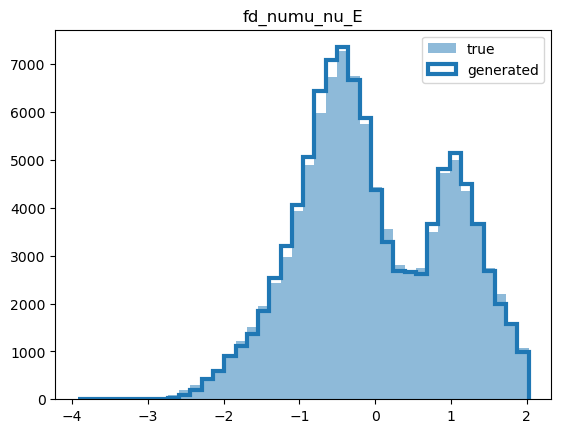

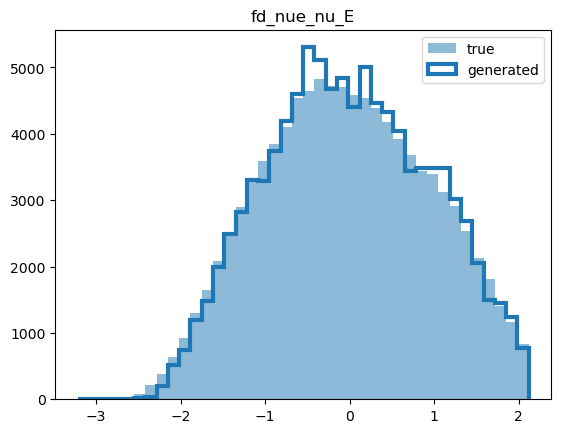

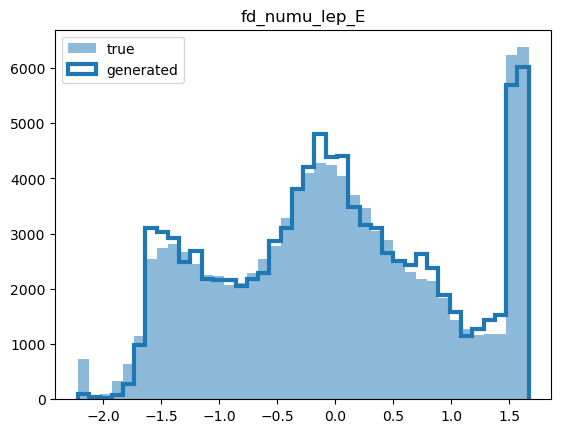

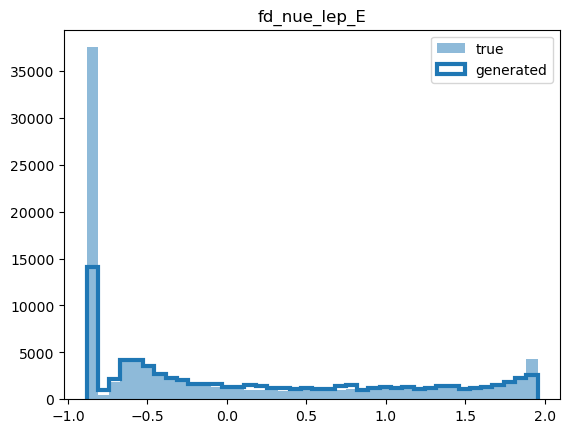

In [159]:
import matplotlib.pyplot as plt

conditions = load_data(DATA_PATH, CONDITION_COLUMNS + FD_COLUMNS)[train_size: train_size + num_new_samples]
conditions = scaler.transform(conditions)
conditions = pd.DataFrame(conditions, columns=CONDITION_COLUMNS + FD_COLUMNS)

for variable in FD_COLUMNS:
    true = conditions[variable]
    bin_range = (true.min(), true.quantile(0.99))
    common_kwargs = dict(bins=40, range=bin_range)
    
    plt.hist(true, label='true', **common_kwargs, histtype='bar', alpha=0.5);
    plt.hist(samples[variable], label='generated', **common_kwargs, color='tab:blue', histtype='step', lw=3);
    plt.legend()
    plt.title(variable)
    plt.show()

In [160]:
# train a classifier on conditions vs true
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np
from sklearn.model_selection import train_test_split

def train_reweighter(conditions, samples):
    clf = HistGradientBoostingClassifier()
    
    data = np.vstack([conditions.values, samples.values])
    labels = np.hstack([np.ones(len(conditions)), np.zeros(len(true))])
    
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    clf.fit(data_train, labels_train)
    
    print(clf.score(data_test, labels_test))
    
    return clf
    

In [163]:
reweighter = train_reweighter(conditions[FD_COLUMNS], samples)


def reweight(reweighter, samples):
    proba = reweighter.predict_proba(samples)
    weights = proba[:, 1] / proba[:, 0]
    return np.clip(weights, 0, 4)

0.7299
